In [36]:
%load_ext ipydex.displaytools
import sympy as sp
from sympy import sin, cos
import symbtools as st
import symbtools.modeltools as mt
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt
sp.init_printing()

The ipydex.displaytools extension is already loaded. To reload it, use:
  %reload_ext ipydex.displaytools


In [2]:
theta1, theta2 = theta = st.symb_vector('theta1:3')
dtheta1, dtheta2 = dtheta = st.time_deriv(theta, theta)
tau = sp.symbols('tau')
params = sp.symbols('m1 l1 J1 mu1 m2 r2 J2 mu2')
st.make_global(params)

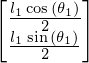

---


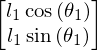

---


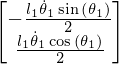

---


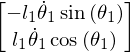

---


In [3]:
p1 = sp.Matrix([l1/2*cos(theta1), l1/2*sin(theta1)]) ##:
p2 = sp.Matrix([l1*cos(theta1), l1*sin(theta1)]) ##:
dp1 = st.time_deriv(p1, theta) ##:
dp2 = st.time_deriv(p2, theta) ##:

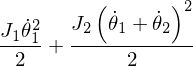

---


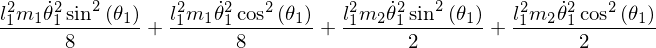

---


---


In [4]:
T_rot = J1 * dtheta1**2 / 2 + J2 * (dtheta1 + dtheta2)**2 / 2 ##:
T_trans = (m1 * dp1.T * dp1 / 2 + m2 * dp2.T * dp2 / 2)[0] ##:
T = T_rot + T_trans
V = 0 ##:
friction1 = dtheta1 * mu1
friction2 = dtheta2 * mu2

In [5]:
model = mt.generate_symbolic_model(T, V, theta, [0 - friction1, tau - friction2])
model.tau = [tau]
model.calc_state_eq()

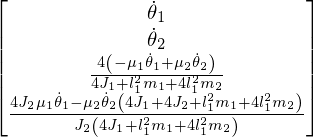

---


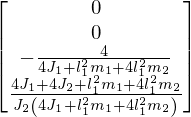

---


In [6]:
f = model.f ##:
g = model.g ##:

In [89]:
m1_val = 0.1
m2_val = 1
l1_val = 0.5
r2_val = 0.1
J1_val = 1/12 * m1_val * l1_val**2
J2_val = 1/2 * m2_val * r2_val**2
mu1_val = 0.0
mu2_val = 0.1

param_subs = st.lzip(params, [m1_val, l1_val, J1_val, mu1_val, m2_val, r2_val, J2_val, mu2_val])

f_fun = st.expr_to_func(model.x, f.subs(param_subs))
g_fun = st.expr_to_func(model.x, g.subs(param_subs))

def tau_fun(t, x):
    return 0.2

def ode_fun(t, x):
    return f_fun(x[0], x[1], x[2], x[3]) + tau_fun(t, x) * g_fun(x[0], x[1], x[2], x[3])

x_init = np.array([0, 0, 0, 2])
tf = 10.0
dt = 1/60
ts = np.arange(0.0, tf, dt)
samples = len(ts)
ys = np.empty((4, samples))
ys[:, 0] = x_init

for i in range(samples - 1):
    result = scipy.integrate.solve_ivp(ode_fun, (ts[i], ts[i+1]), ys[:, i])
    ys[:, i+1] = result.y[:, -1]

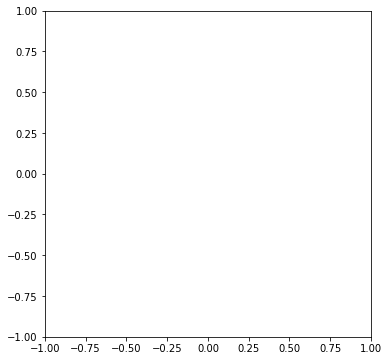

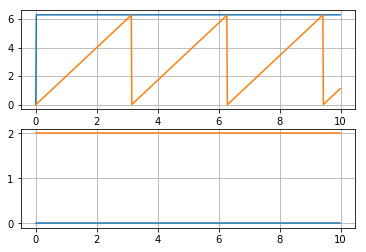

In [90]:
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-1, 1), ylim=(-1,1))
ax.set_aspect('equal')

line, = ax.plot([],[],'o-', lw=2)
time_template = 'time=%.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)


def init():
    line.set_data([],[])
    time_text.set_text('')
    return line, time_text

def animate(i):
    xi = ys[:, i]
    xx = np.array([0.0, l1_val * np.cos(xi[0]), l1_val * np.cos(xi[0]) + r2_val * np.cos(xi[0]+xi[1])])
    yy = np.array([0.0, l1_val * np.sin(xi[0]), l1_val * np.sin(xi[0]) + r2_val * np.sin(xi[0]+xi[1])])
    
    line.set_data(xx,yy)
    time_text.set_text(time_template%(i*dt))
    return line, time_text


ani = animation.FuncAnimation(fig, animate, range(samples), interval=dt*1000, blit=True, init_func=init)
#HTML(ani.to_jshtml())

plt.figure()
plt.subplot(211)
plt.plot(ts, np.mod(ys[0, :], 2*np.pi))
plt.plot(ts, np.mod(ys[1, :], 2*np.pi))
plt.grid()

plt.subplot(212)
plt.plot(ts, ys[2, :])
plt.plot(ts, ys[3, :])
plt.grid()
plt.show()

In [91]:
HTML(ani.to_html5_video())

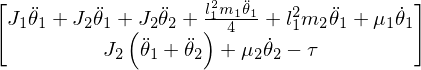

In [88]:
model.eqns